In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k

from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader
from tf_lab.point_clouds.raw_gan import RawGAN
from tf_lab.point_clouds.raw_gan_gp import RawGAN_GP
from tf_lab.point_clouds.latent_gan import LatentGAN
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder


from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, jensen_shannon_divergence, \
                                     sample_pclouds_distances

from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.autopredictors.exploration import find_neighbors

from tf_lab.nips.helper import pclouds_centered_and_half_sphere

from tf_lab.point_clouds.generators_discriminators import latent_code_discriminator_two_layers, latent_code_generator_two_layers    

from tf_lab.icml.ae_farm_helper import relevant_class

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
do_training = True
do_plotting = True
ae_loss = 'emd'

save_synthetic_samples = True
save_model = True
saver_step = 10

class_name = raw_input('Give me the class type: ').lower()
ae_id = raw_input('Give me the AE/experiment ID: ').lower()
cmp_type = raw_input('Comparison Type ("best" epoch vs. "max_min" epoch): ').lower()

syn_id = shape_net_category_to_synth_id()[class_name]

experiment_name = '_'.join(['nb_wgan_gp_ae', ae_id, ae_loss, class_name, str(n_pc_samples), cmp_type, 'epoch'])

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/synthetic_point_clouds'

train_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/gan/nb_gan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir);

Give me the class type: chair
Give me the AE/experiment ID: 14
Comparison Type ("best" epoch vs. "max_min" epoch): best


In [5]:
# Load Raw Point-Clouds of class
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )

6778 files containing complete point clouds were found.


In [6]:
ae_help = relevant_class(ae_loss)

In [7]:
# Load Auto-Encoder
ae_net_name = 'ae_farm_' + class_name + '_conv_arch_' + ae_id + '_2048pts_' + ae_loss
ae_net_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/ae_farming', ae_net_name)
ae_conf = Conf.load(osp.join(ae_net_dir, 'configuration'))
reset_tf_graph()
ae = PointNetAutoEncoder(ae_net_name, ae_conf)
bneck = ae.bottleneck_size
assert(ae_help.experiment_id_to_bneck[int(ae_id)] == bneck) 

if cmp_type.startswith('best'):
    load_epoch, _ = ae_help.best_epochs[bneck]
    print load_epoch
elif cmp_type.startswith('max'):
    load_epoch, _ = ae_help.max_min_epochs[bneck]
else:
    assert(False)
    saved_epochs = read_saved_epochs(ae_conf.train_dir)
    load_epoch = saved_epochs[-1]

ae.restore_model(ae_conf.train_dir, load_epoch, verbose=True)

990
Model restored in epoch 990.


In [8]:
# Convert raw-data to latent codes.
raw_data = PointCloudDataSet(pclouds, init_shuffle=False)
_, latent_codes, _ = latent_embedding_of_entire_dataset(raw_data, ae, ae_conf)
training_data = PointCloudDataSet(latent_codes)

In [9]:
# TODO : make GAN conf.
init_lr = 0.0001
batch_size = 50

noise_params = {'mu':0, 'sigma': 0.5}
noise_dim = ae.bottleneck_size
max_epochs = 500

n_syn_samples = training_data.num_examples  # Same number as original GT data.
n_out = [ae.bottleneck_size]

lam = 10
beta = 0.5
disc_kwargs = {'b_norm': False}
reset_tf_graph()
gan = RawGAN_GP(experiment_name, init_lr, lam, n_out, noise_dim,\
                latent_code_discriminator_two_layers, latent_code_generator_two_layers,\
                beta=beta, disc_kwargs=disc_kwargs)


1 (-1.3637028014218366, 1.7288765490606979)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


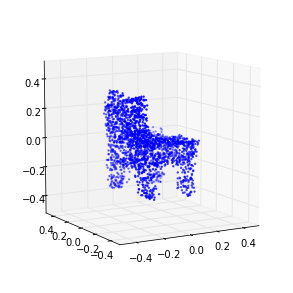

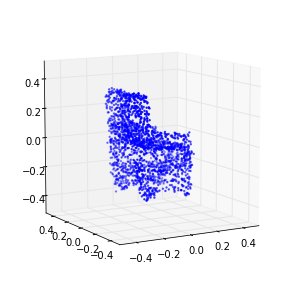

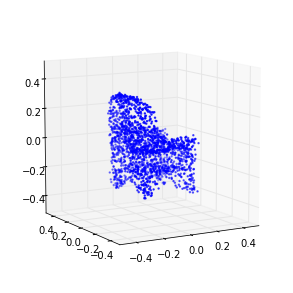

2 (-1.425903820991516, 1.7624847800643355)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-2 is not in all_model_checkpoint_paths. Manually adding it.


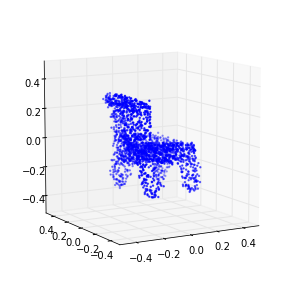

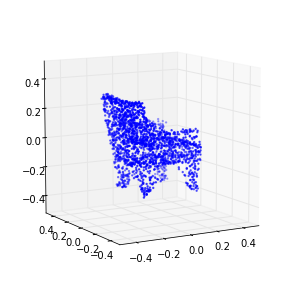

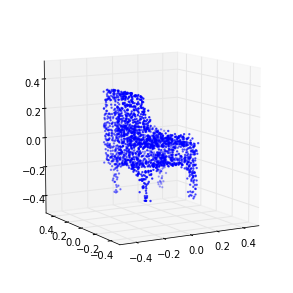

3 (-0.99282421447612623, 1.2584046037108809)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-3 is not in all_model_checkpoint_paths. Manually adding it.


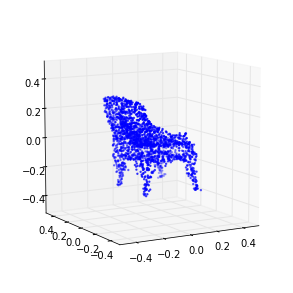

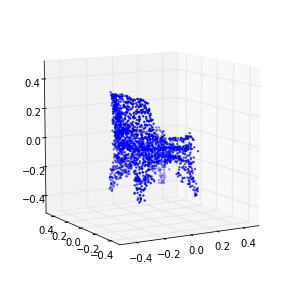

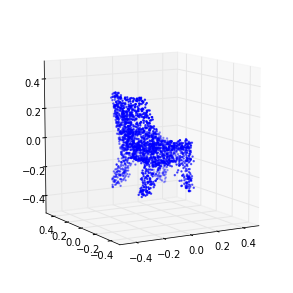

4 (-0.79915953256465766, 0.93039516607920325)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-4 is not in all_model_checkpoint_paths. Manually adding it.


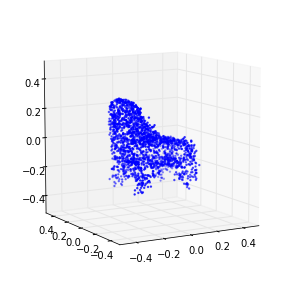

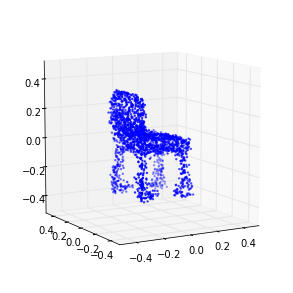

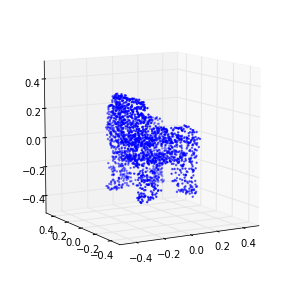

5 (-0.73145351718973228, 0.66463870913894085)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.


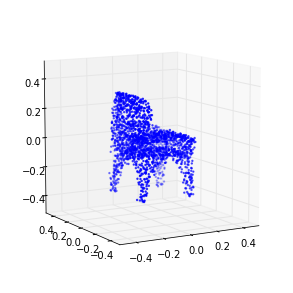

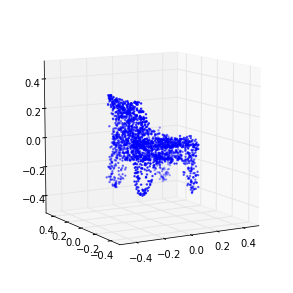

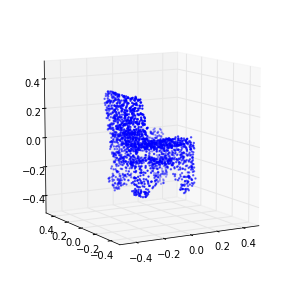

6 (-0.73989757740939111, 0.47016266981760663)
7 (-0.74738668512415007, 0.3463943468199836)
8 (-0.75405543954284104, 0.27296104309735475)
9 (-0.7566391821260805, 0.22440962934935535)
10 (-0.7618344042036268, 0.18488457247062964)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.


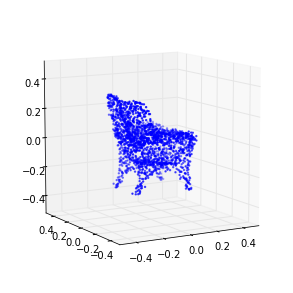

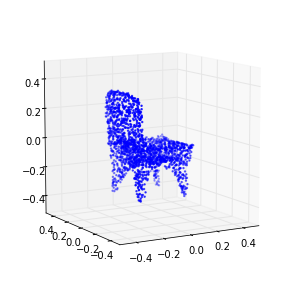

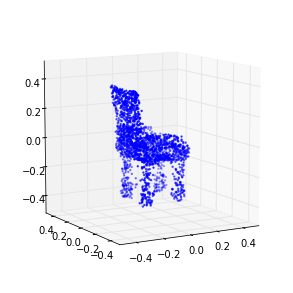

11 (-0.76319550319954199, 0.15298931880129707)
12 (-0.76237427702656502, 0.1225017703793667)
13 (-0.75964581657339025, 0.099264646569887802)
14 (-0.75703465585355401, 0.086391144052699764)
15 (-0.75299742310135453, 0.061835192419864515)
16 (-0.74977107401247378, 0.046923846489301431)
17 (-0.74305688584292373, 0.035195011955996357)
18 (-0.73971388825663809, 0.026524900010338536)
19 (-0.73870510481022023, 0.020830881919849803)
20 (-0.73480010032653809, 0.0061927055681331288)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-20 is not in all_model_checkpoint_paths. Manually adding it.


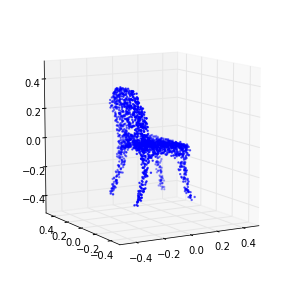

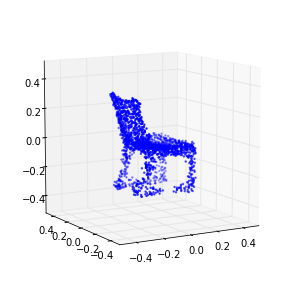

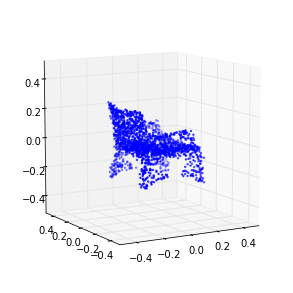

21 (-0.73297866671173662, 0.0029725497416048137)
22 (-0.72902543147404986, -0.0024495131111945266)
23 (-0.7248159514533149, -0.015541192083792002)
24 (-0.71600766932522808, -0.012163224996550492)
25 (-0.70551881127887306, -0.01764733971234549)
26 (-0.69569323195351496, -0.016338610331769341)
27 (-0.68582734399371681, -0.027254686949567661)
28 (-0.67563943598005505, -0.01995686638272471)
29 (-0.66810445741370872, -0.02646095179780214)
30 (-0.65602490504582722, -0.037095217292921409)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-30 is not in all_model_checkpoint_paths. Manually adding it.


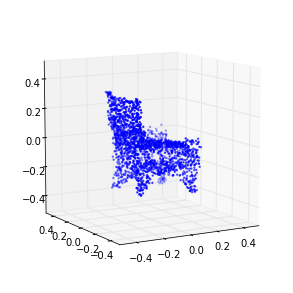

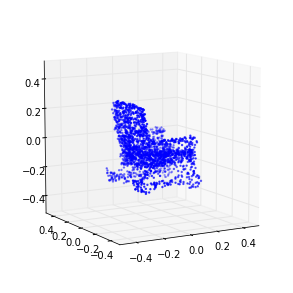

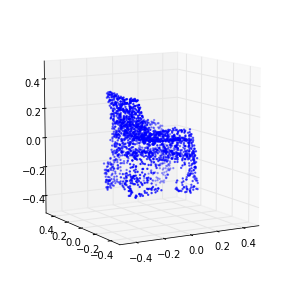

31 (-0.64890741109848027, -0.037058698444592732)
32 (-0.64063051983162211, -0.02301531178980238)
33 (-0.63256528421684544, -0.048978111068545667)
34 (-0.62500047418806293, -0.044009970268234611)
35 (-0.61827723935798362, -0.039205762229997804)
36 (-0.61535735925038659, -0.05859363596472475)
37 (-0.6112766124584057, -0.051969114182240983)
38 (-0.60758090195832426, -0.070161392153413202)
39 (-0.59896593270478427, -0.062070080734513422)
40 (-0.59340881153389258, -0.061704772559029085)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-40 is not in all_model_checkpoint_paths. Manually adding it.


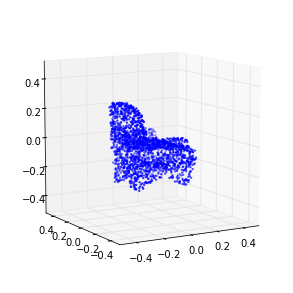

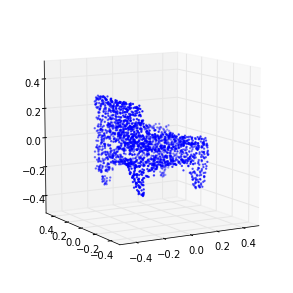

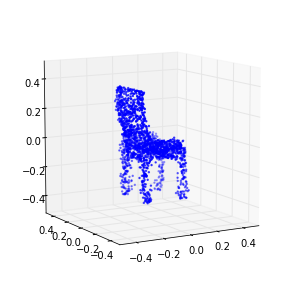

41 (-0.58520224491755168, -0.073687180807745015)
42 (-0.57712221454691004, -0.064949772010246917)
43 (-0.57023054582101329, -0.080495436434392581)
44 (-0.56055254273944433, -0.0788377904229694)
45 (-0.55239237105404893, -0.077035908276836082)
46 (-0.54363438288370769, -0.095258149835798472)
47 (-0.53546969051714299, -0.094085917152740339)
48 (-0.5281294957355217, -0.098440567100489582)
49 (-0.52095117436514959, -0.11377238565021092)
50 (-0.51304806250113033, -0.11473388721545537)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-50 is not in all_model_checkpoint_paths. Manually adding it.


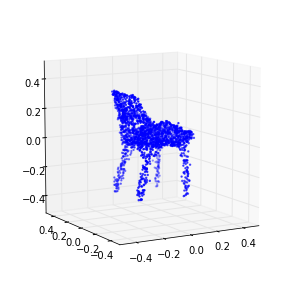

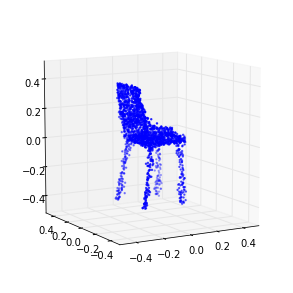

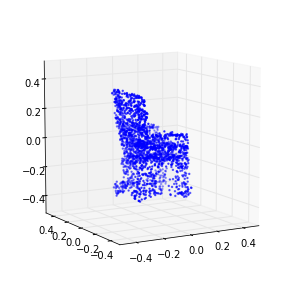

51 (-0.50866705775260923, -0.12141072832875782)
52 (-0.50446528019728487, -0.13879602678396083)
53 (-0.49656486268396732, -0.14731067198294182)
54 (-0.49327772635000722, -0.14451442465738015)
55 (-0.48703293667899239, -0.16307218869527182)
56 (-0.48049923027003255, -0.15643758878663735)
57 (-0.47574295644406916, -0.17059243387646145)
58 (-0.47023607889811198, -0.17518627588395719)
59 (-0.46295120760246561, -0.18396789773746772)
60 (-0.4558457972826781, -0.18635953631665972)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-60 is not in all_model_checkpoint_paths. Manually adding it.


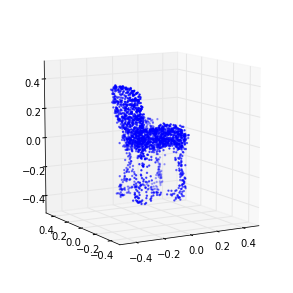

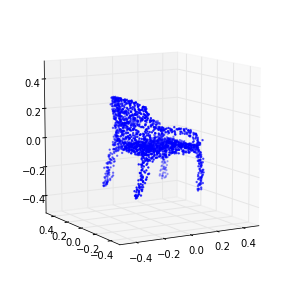

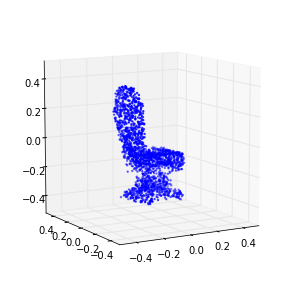

61 (-0.45008945178102566, -0.19122989586106054)
62 (-0.44334697458479139, -0.20653022273823066)
63 (-0.43606854964185643, -0.21698731680711111)
64 (-0.43110909859339397, -0.21334777772426605)
65 (-0.42379551463656956, -0.23615174271442271)
66 (-0.41617236887967146, -0.23513857192463344)
67 (-0.41024598059830841, -0.24752709600660536)
68 (-0.40310532693509704, -0.25806951302069203)
69 (-0.39519197013643054, -0.270812906048916)
70 (-0.39006240610723142, -0.28253999738781538)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-70 is not in all_model_checkpoint_paths. Manually adding it.


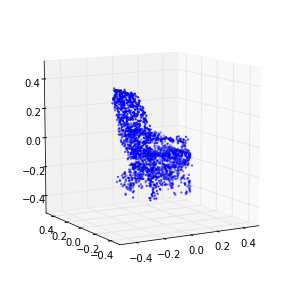

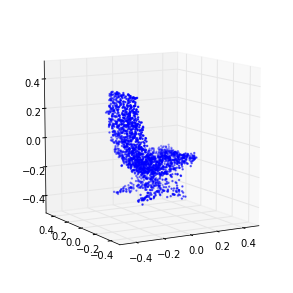

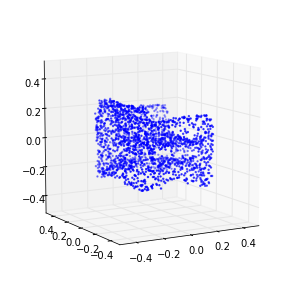

71 (-0.38341614449465716, -0.28543405400382149)
72 (-0.37531866983131124, -0.30152374064480819)
73 (-0.37181666338885272, -0.30173313617706299)
74 (-0.36705625498736344, -0.31410413097452233)
75 (-0.35987492225788259, -0.33750207998134474)
76 (-0.35383886120937491, -0.3307091847614006)
77 (-0.34952715878133422, -0.34666032702834521)
78 (-0.34377071040648, -0.35934170087178546)
79 (-0.33701715668042503, -0.36563317753650526)
80 (-0.33542895361229225, -0.37265517976548934)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-80 is not in all_model_checkpoint_paths. Manually adding it.


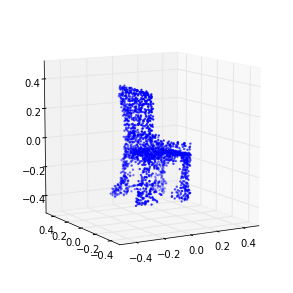

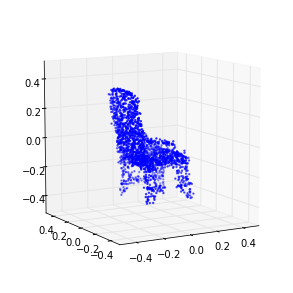

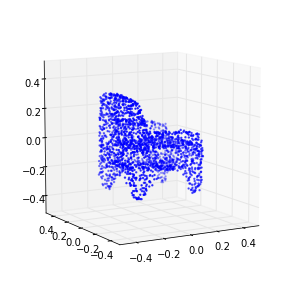

81 (-0.32933221062024437, -0.38978605800204807)
82 (-0.32446251511573793, -0.39923210497255679)
83 (-0.31993176363132619, -0.41800721817546421)
84 (-0.31616646007255272, -0.40028056391963251)
85 (-0.31230588290426464, -0.4264258764408253)
86 (-0.30783271502565457, -0.43100560152972184)
87 (-0.30372844559175, -0.42812809237727412)
88 (-0.30218902473096493, -0.4584369284135324)
89 (-0.29606676454897279, -0.45971868435541791)
90 (-0.29192582865556083, -0.46806013804894908)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-90 is not in all_model_checkpoint_paths. Manually adding it.


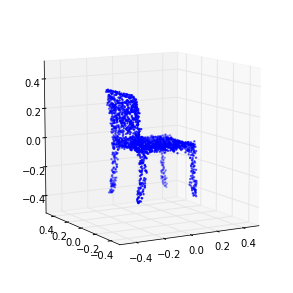

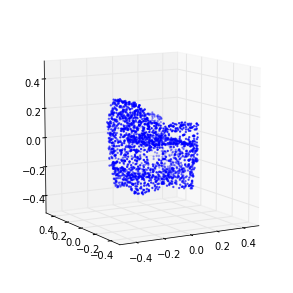

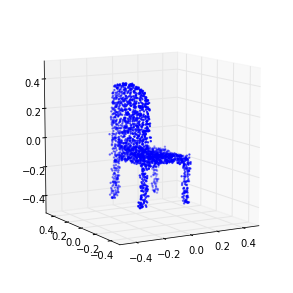

91 (-0.28855995900101133, -0.47437104141270675)
92 (-0.28423377165087949, -0.46930249200926888)
93 (-0.27774218663021372, -0.48922564254866707)
94 (-0.27658719000992954, -0.49676582327595464)
95 (-0.27258077837802747, -0.49552689216755053)
96 (-0.26832011452427618, -0.50468941088075991)
97 (-0.26362651255395675, -0.5034433161770856)
98 (-0.26083790516411814, -0.50326102751272694)
99 (-0.25619665130420965, -0.50531001444216128)
100 (-0.25287818809350332, -0.51988453887127062)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-100 is not in all_model_checkpoint_paths. Manually adding it.


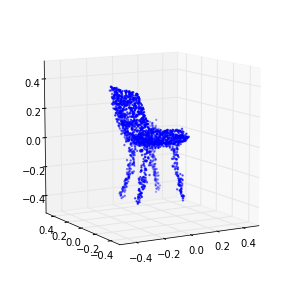

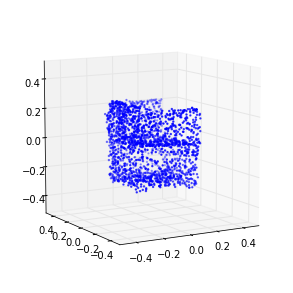

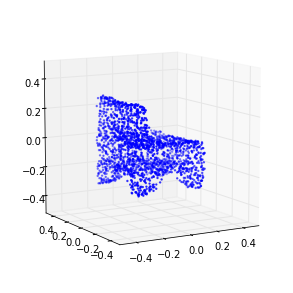

101 (-0.24871665603584714, -0.5303290729169492)
102 (-0.24298766763121993, -0.52277998460663688)
103 (-0.24141456297150365, -0.53126552259480508)
104 (-0.2357452587948905, -0.53501369224654305)
105 (-0.23086836051057885, -0.55552806898399631)
106 (-0.23041311138206058, -0.55262865622838342)
107 (-0.2248736995237845, -0.5372928358890392)
108 (-0.22320254996970848, -0.55291718244552612)
109 (-0.22058580617109935, -0.56007427860189363)
110 (-0.21670110733420761, -0.57111577192942298)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-110 is not in all_model_checkpoint_paths. Manually adding it.


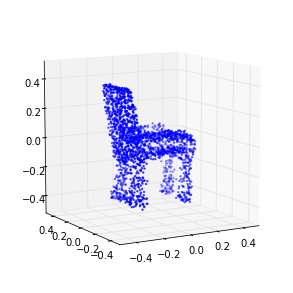

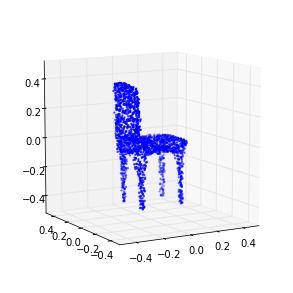

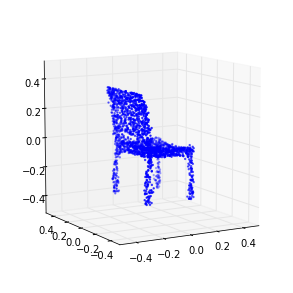

111 (-0.21394343431349153, -0.56405210274237172)
112 (-0.2092621879445182, -0.57342344743234142)
113 (-0.20987423117514009, -0.57969449846832843)
114 (-0.20287174196154983, -0.57373193237516618)
115 (-0.20173758500152164, -0.58880466002005116)
116 (-0.20012174899931306, -0.58473015493816805)
117 (-0.20059304193214134, -0.60460519790649414)
118 (-0.19788879912208629, -0.60748764320656101)
119 (-0.19354375656004305, -0.60020228006221632)
120 (-0.19074064669785676, -0.59332838102623264)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-120 is not in all_model_checkpoint_paths. Manually adding it.


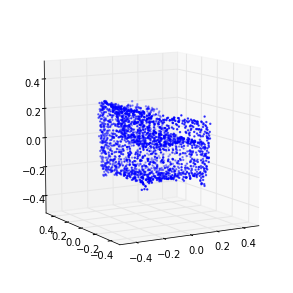

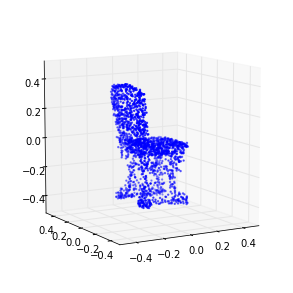

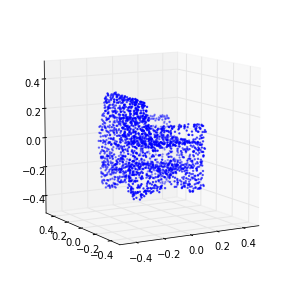

121 (-0.18946992964656265, -0.60383271067230793)
122 (-0.1858015583621131, -0.60731345856631247)
123 (-0.18357021433335763, -0.61795990996890593)
124 (-0.18408868566707329, -0.60180466042624581)
125 (-0.18340217415933255, -0.60570571819941199)
126 (-0.17854806372412929, -0.59183798233668006)
127 (-0.17815388568021634, -0.60533504132871274)
128 (-0.17345903797282114, -0.59188888911847715)
129 (-0.17745634267727534, -0.6036128026467783)
130 (-0.17363388670815361, -0.60537894566853845)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-130 is not in all_model_checkpoint_paths. Manually adding it.


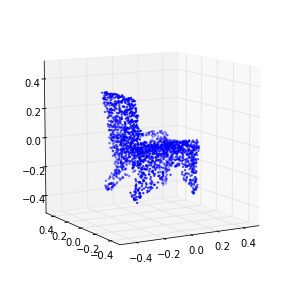

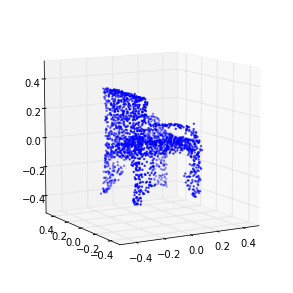

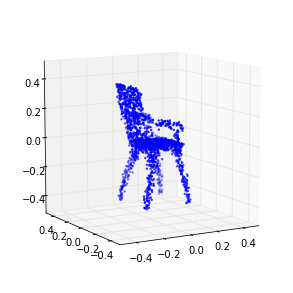

131 (-0.17112352660408728, -0.5971656287157977)
132 (-0.17168025015680879, -0.59274245412261395)
133 (-0.17038175921749185, -0.58686354866734258)
134 (-0.16824975504919334, -0.61167754950346775)
135 (-0.16402714246952976, -0.60072580531791409)
136 (-0.16309438320221725, -0.58807079438809995)
137 (-0.16455583688285616, -0.59477153972343166)
138 (-0.16545693857802285, -0.60242233673731482)
139 (-0.16277325633499357, -0.58500040902031791)
140 (-0.16511532559438988, -0.5839294371781526)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-140 is not in all_model_checkpoint_paths. Manually adding it.


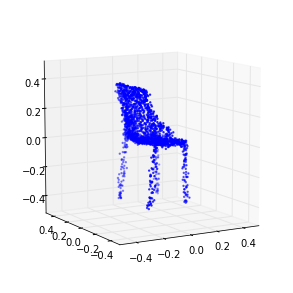

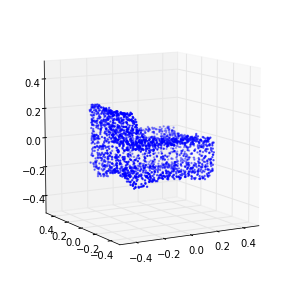

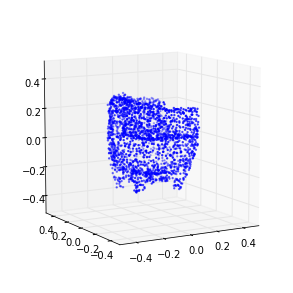

141 (-0.16452371831293458, -0.58616525597042513)
142 (-0.16455622569278436, -0.5839587891543353)
143 (-0.16356737420514778, -0.57613213857014978)
144 (-0.16605147653155858, -0.56950890134882048)
145 (-0.16677927744609339, -0.56832997224949022)
146 (-0.16574006411764358, -0.55435613128874039)
147 (-0.16733191918443752, -0.56107662562970761)
148 (-0.16955533540911144, -0.54745633734597099)
149 (-0.17142841998073791, -0.55173933947527853)
150 (-0.16972139676411946, -0.53524802238852887)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-150 is not in all_model_checkpoint_paths. Manually adding it.


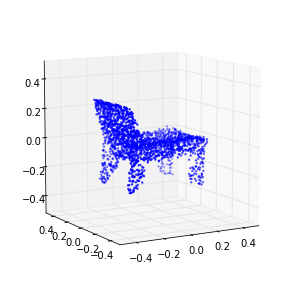

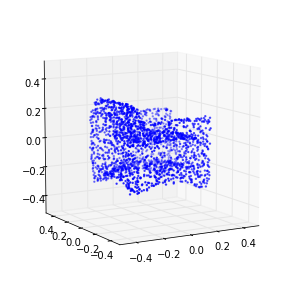

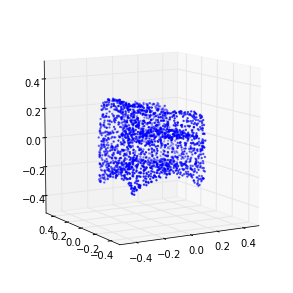

151 (-0.17338903419397494, -0.52824232313368058)
152 (-0.17180746109397324, -0.54464363168787078)
153 (-0.17237190576615158, -0.51426774153002985)
154 (-0.16923286247032659, -0.51948784236554746)
155 (-0.17200020557200468, -0.51484082694406863)
156 (-0.17307528500203734, -0.50637089875009322)
157 (-0.17393241706821655, -0.52122855627978293)
158 (-0.17295041879018147, -0.5023305471296664)
159 (-0.17195812717632011, -0.50181254523771779)
160 (-0.17295999554572283, -0.49564008801071729)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-160 is not in all_model_checkpoint_paths. Manually adding it.


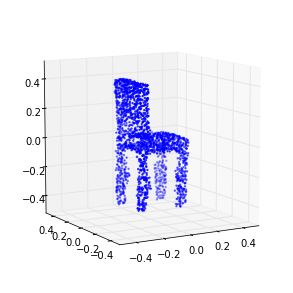

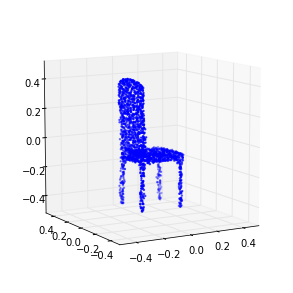

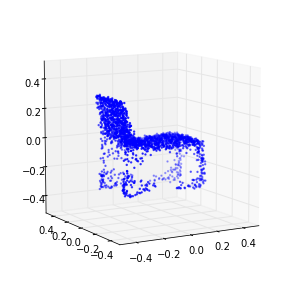

161 (-0.17026561228213488, -0.49023542470402187)
162 (-0.1707408720144519, -0.4893965544524016)
163 (-0.17429684207395271, -0.48457652109640614)
164 (-0.17346779494373887, -0.45866526166598004)
165 (-0.17296031051211888, -0.4637794616045775)
166 (-0.17515749798880684, -0.46287267737918431)
167 (-0.17484515955050786, -0.46395076976882088)
168 (-0.17533615248070822, -0.45698178255999528)
169 (-0.17126876921565445, -0.46042342759944777)
170 (-0.17506461767134843, -0.43736136401141129)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-170 is not in all_model_checkpoint_paths. Manually adding it.


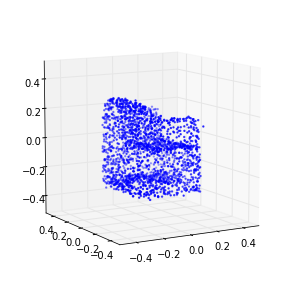

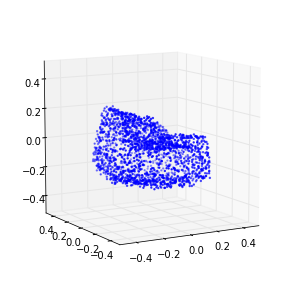

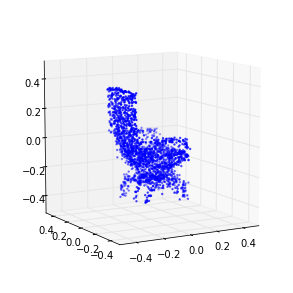

171 (-0.17602619561884139, -0.4491359900545191)
172 (-0.17598500224175276, -0.43916937708854675)
173 (-0.17531082690865904, -0.43512300871036669)
174 (-0.17864329268534979, -0.42529841926362777)
175 (-0.17793979694445927, -0.42258965527569808)
176 (-0.1736869321929084, -0.42823665009604561)
177 (-0.17700772097817175, -0.42865140239397687)
178 (-0.17631745211504124, -0.42825331069805006)
179 (-0.17469869250500644, -0.42803250308390017)
180 (-0.17718734051342364, -0.40948765366165724)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-180 is not in all_model_checkpoint_paths. Manually adding it.


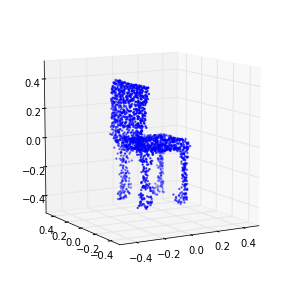

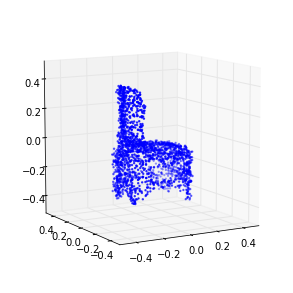

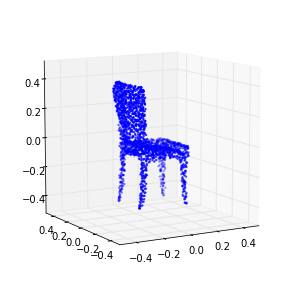

181 (-0.17867295714440168, -0.42413947096577398)
182 (-0.17714723563856549, -0.43067718214458889)
183 (-0.1805726190408071, -0.42209516079337511)
184 (-0.17909241235918469, -0.41018024418089127)
185 (-0.17776848762123673, -0.409620671360581)
186 (-0.17883198504094724, -0.38982506261931527)
187 (-0.17939410756031673, -0.40959809444568773)
188 (-0.17592869549989701, -0.39820781902030661)
189 (-0.18023197054862977, -0.39328510893715751)
190 (-0.17909615497898174, -0.40424632253470244)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-190 is not in all_model_checkpoint_paths. Manually adding it.


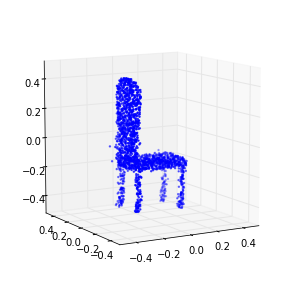

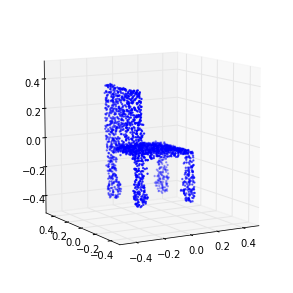

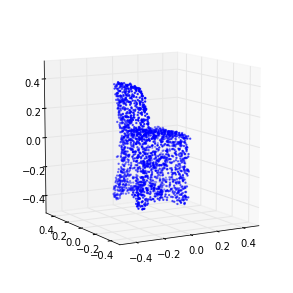

191 (-0.18062973894454815, -0.39766114287906223)
192 (-0.18139259627571813, -0.39510066972838509)
193 (-0.17769763668378194, -0.38827910357051426)
194 (-0.18304918513253884, -0.3726490482136055)
195 (-0.18039865808354483, -0.37720102182141058)
196 (-0.17951258718967439, -0.38172851668463814)
197 (-0.17902796814839045, -0.37376983077437792)
198 (-0.17849089757159906, -0.37128649044919898)
199 (-0.18337039202451705, -0.3686406667585726)
200 (-0.18054869213589916, -0.38014754101082132)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-200 is not in all_model_checkpoint_paths. Manually adding it.


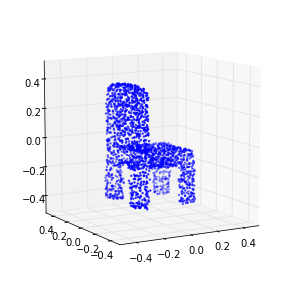

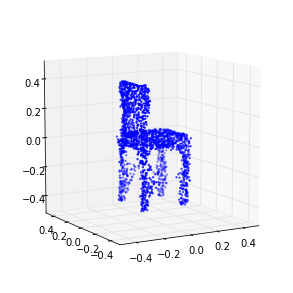

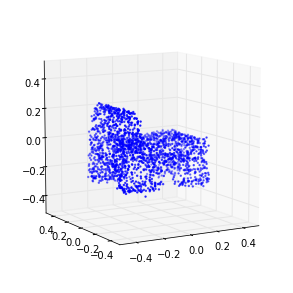

201 (-0.1820362737885228, -0.3533082902431488)
202 (-0.18039723281507139, -0.34980240905726395)
203 (-0.18081978217319206, -0.35424818264113533)
204 (-0.18542143525900665, -0.33474573161866927)
205 (-0.18432995136137362, -0.3523756707156146)
206 (-0.18152003100624792, -0.33781940076086259)
207 (-0.18160406941616977, -0.3396928133787932)
208 (-0.18216591466356208, -0.3327008231922432)
209 (-0.18392880862509764, -0.3407908655979015)
210 (-0.18341951491656128, -0.33976423078113133)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-210 is not in all_model_checkpoint_paths. Manually adding it.


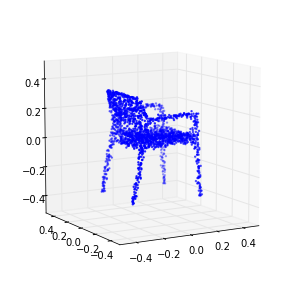

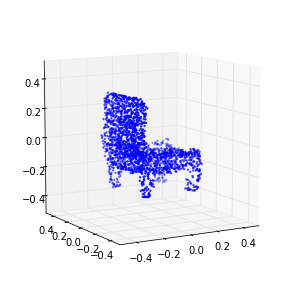

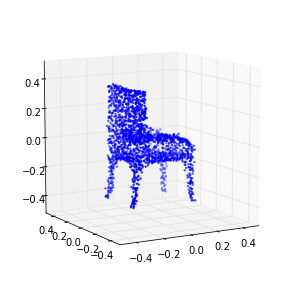

211 (-0.18299979666868846, -0.33084343649722914)
212 (-0.18136448098553551, -0.33099620982452677)
213 (-0.18401527840782095, -0.32718026417273061)
214 (-0.17979405947305538, -0.32388816829080935)
215 (-0.18501778244972228, -0.3117994997236464)
216 (-0.18240937866546489, -0.3174290546664485)
217 (-0.18322921742995579, -0.32278230455186629)
218 (-0.18473561908359881, -0.3185970694930465)
219 (-0.18480727976119077, -0.31515819275820695)
220 (-0.18702833900849025, -0.3178546064429813)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-220 is not in all_model_checkpoint_paths. Manually adding it.


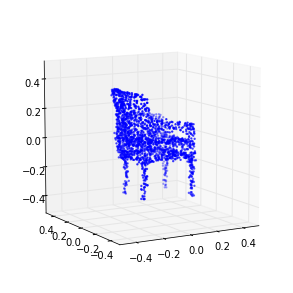

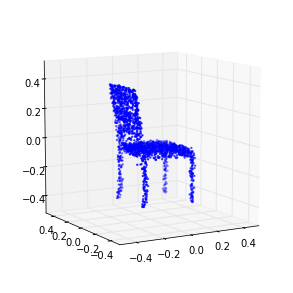

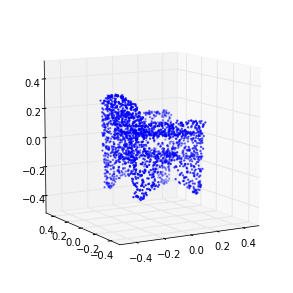

221 (-0.1835884999897745, -0.30781811034237899)
222 (-0.1847296130877954, -0.32628185439992835)
223 (-0.18430758482880064, -0.30619605492662499)
224 (-0.18145558558128499, -0.29884324140018886)
225 (-0.18567863161917086, -0.30696170970245645)
226 (-0.18427202878174959, -0.29206614251489993)
227 (-0.18549287043235921, -0.29953825639353859)
228 (-0.18426725787145121, -0.29608960725643019)
229 (-0.18544956743717195, -0.30258885688251919)
230 (-0.1852300731120286, -0.29481160309579635)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-230 is not in all_model_checkpoint_paths. Manually adding it.


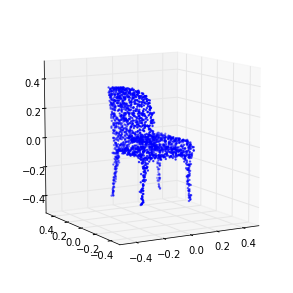

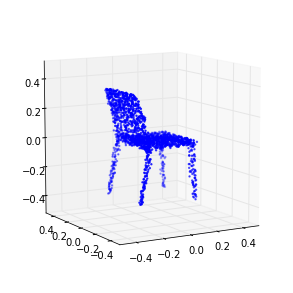

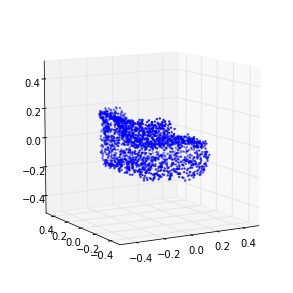

231 (-0.18612862715014705, -0.30333179566595292)
232 (-0.18447240204722792, -0.29792326136871622)
233 (-0.18574488047096466, -0.30022210655389009)
234 (-0.18796907028666249, -0.29996163094485245)
235 (-0.18672992653316922, -0.30224671407982157)
236 (-0.18624637402870037, -0.30684711646150659)
237 (-0.18669463285693416, -0.30622330528718456)
238 (-0.18536297491303197, -0.28214521154209421)
239 (-0.18820850976087428, -0.30037708856441359)
240 (-0.18981654191458666, -0.2947045619840975)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-240 is not in all_model_checkpoint_paths. Manually adding it.


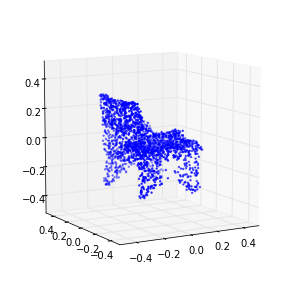

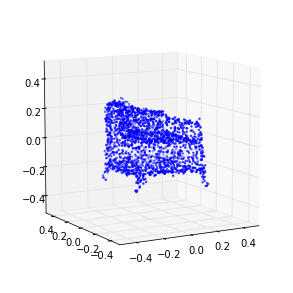

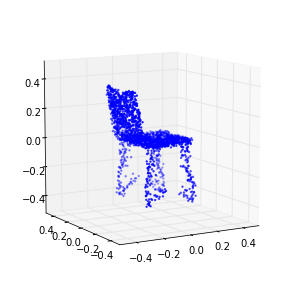

241 (-0.18797418635200572, -0.29038023286395603)
242 (-0.1884559401759395, -0.29381947053803337)
243 (-0.18790622640539098, -0.28963428073459202)
244 (-0.18702204122587487, -0.29010666962023135)
245 (-0.1865051183435652, -0.28361962625273951)
246 (-0.18774182917895141, -0.28832682084154199)
247 (-0.18749940836871112, -0.2855349569408982)
248 (-0.18931089242299398, -0.29079162191461633)
249 (-0.18687503735224406, -0.29152041894418224)
250 (-0.18621752140698611, -0.2862033275542436)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-250 is not in all_model_checkpoint_paths. Manually adding it.


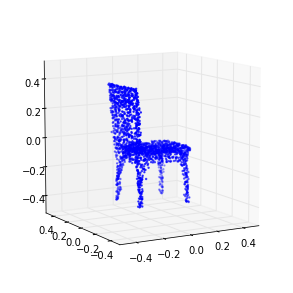

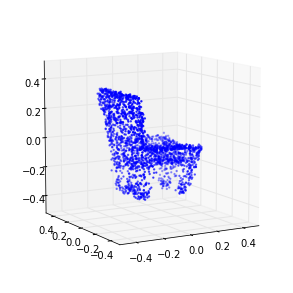

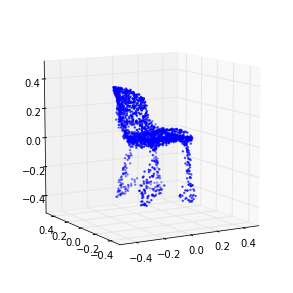

251 (-0.18934244160298949, -0.29125549616637053)
252 (-0.1889926176380228, -0.27692391088715307)
253 (-0.18670869171619414, -0.2774887885208483)
254 (-0.18738460143407185, -0.28515019460960672)
255 (-0.18665024439493816, -0.26642496331974314)
256 (-0.19008508997934837, -0.27697700703585587)
257 (-0.19006843898031447, -0.26710170231483599)
258 (-0.18858035085377869, -0.27758847728923514)
259 (-0.19198171606770267, -0.27214959760506946)
260 (-0.1890861130974911, -0.26981588535838658)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-260 is not in all_model_checkpoint_paths. Manually adding it.


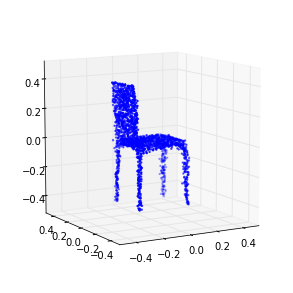

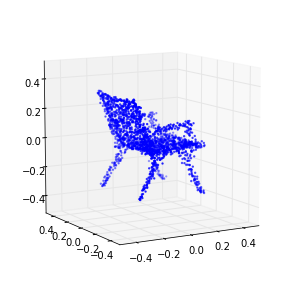

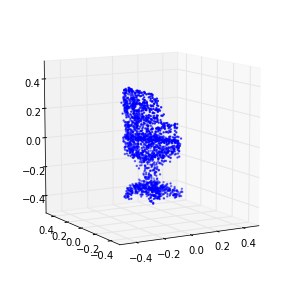

261 (-0.19081624702171043, -0.27400568734716485)
262 (-0.19124061674983414, -0.26519102244465437)
263 (-0.18881117149635598, -0.27006983370692644)
264 (-0.19113871234434623, -0.26352519348815634)
265 (-0.19150440163082547, -0.25526546438535053)
266 (-0.18936849115071475, -0.25356021909802046)
267 (-0.19172227780024212, -0.26591698604601399)
268 (-0.19149263401826222, -0.25273444200003586)
269 (-0.19113680632026106, -0.25998249925948957)
270 (-0.19071872653784575, -0.24610252678394318)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-270 is not in all_model_checkpoint_paths. Manually adding it.


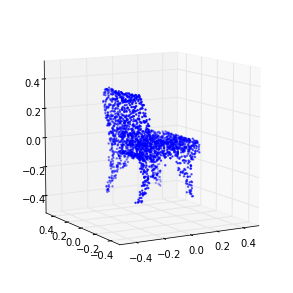

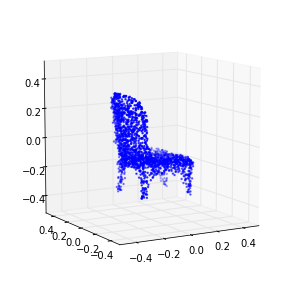

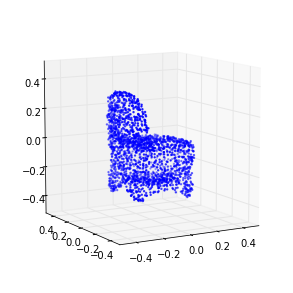

271 (-0.19059786183966532, -0.24516173424544158)
272 (-0.19165609622443164, -0.2440557634388959)
273 (-0.19014955924616919, -0.25554375791991196)
274 (-0.1894930496259972, -0.24608787176785646)
275 (-0.18867419041969158, -0.23389890127711827)
276 (-0.19104509971759936, -0.25504129186824515)
277 (-0.19106502698527442, -0.24948416650295258)
278 (-0.18929008653870336, -0.23665763272179496)
279 (-0.19203733636273279, -0.23811669426935692)
280 (-0.18950247599018943, -0.24000034674450202)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-280 is not in all_model_checkpoint_paths. Manually adding it.


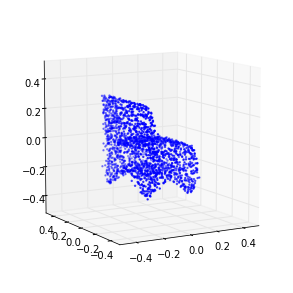

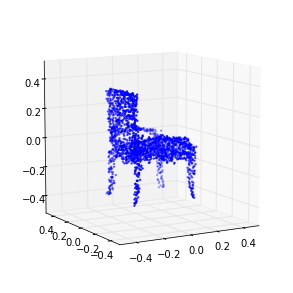

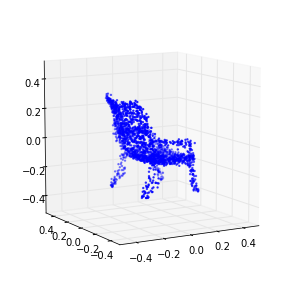

281 (-0.18965674136523847, -0.24223780963155958)
282 (-0.18932314294355887, -0.24152003725369772)
283 (-0.19001578191916149, -0.2445196040250637)
284 (-0.18948220257405882, -0.23885667931150506)
285 (-0.18978479427319986, -0.23102950111583428)
286 (-0.19130558636453415, -0.24064147803518507)
287 (-0.19110421240329742, -0.23967938952975804)
288 (-0.18956151516349226, -0.23145208204234088)
289 (-0.1883266270160675, -0.22376747263802421)
290 (-0.19084856361150743, -0.21974667354866309)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-290 is not in all_model_checkpoint_paths. Manually adding it.


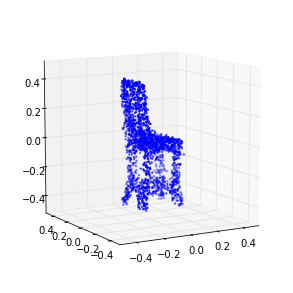

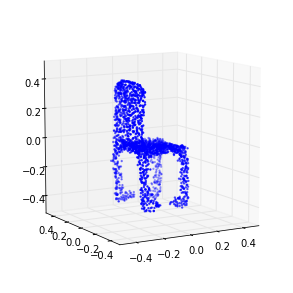

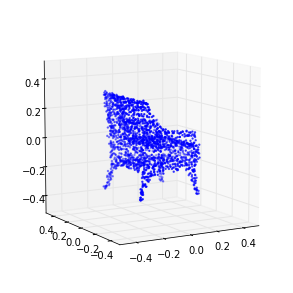

291 (-0.1886593637643037, -0.24318969360104314)
292 (-0.19238589074876572, -0.23214961698761694)
293 (-0.19072941585823341, -0.22919604844517177)
294 (-0.1890798470488301, -0.22479398162276656)
295 (-0.19094933679810278, -0.22732459781346498)
296 (-0.19119576094327151, -0.22573673504370231)
297 (-0.19215160332344197, -0.22190796335538229)
298 (-0.19002805407400483, -0.22190490420217868)
299 (-0.1896559488994104, -0.22936380406220755)
300 (-0.19522222639233977, -0.21282393071386549)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-300 is not in all_model_checkpoint_paths. Manually adding it.


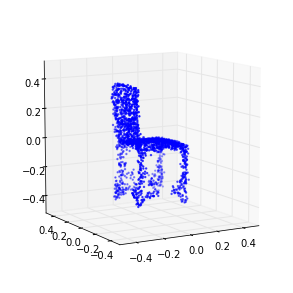

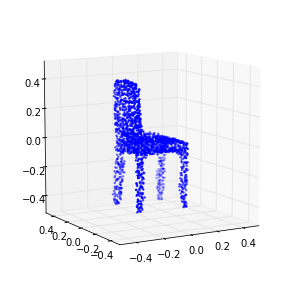

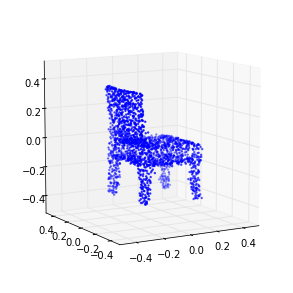

301 (-0.19164491880823065, -0.22145414573174935)
302 (-0.19251592953999838, -0.2228187283983937)
303 (-0.19241093054965691, -0.2220686806572808)
304 (-0.19134615361690521, -0.218524522251553)
305 (-0.19078536232312521, -0.20680394382388503)
306 (-0.19219416876633963, -0.21199254415653371)
307 (-0.1919017263032772, -0.20092299194247634)
308 (-0.19180483210969854, -0.20468352569474113)
309 (-0.19116092710583299, -0.2146493704230697)
310 (-0.1915248496664895, -0.19776580565505558)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-310 is not in all_model_checkpoint_paths. Manually adding it.


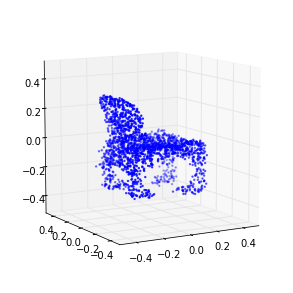

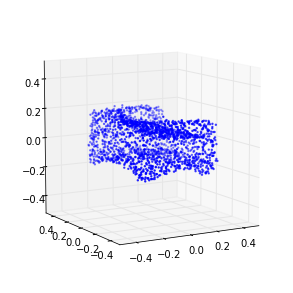

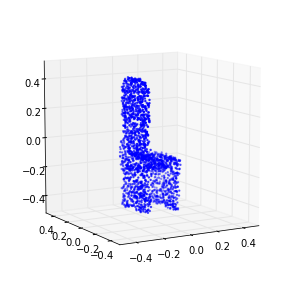

311 (-0.19089596481234938, -0.20116393764813742)
312 (-0.19099191901860413, -0.20174051821231842)
313 (-0.19146167415159721, -0.19825153218375313)
314 (-0.19068613140671342, -0.20103422028047066)
315 (-0.19202461584850594, -0.19902983363027926)
316 (-0.18996262318558163, -0.19522746238443586)
317 (-0.19257022738456725, -0.19168177688563312)
318 (-0.19229828130315851, -0.19119875574553455)
319 (-0.19349076019393074, -0.19212051784550702)
320 (-0.19365717062243709, -0.1917602911039635)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-320 is not in all_model_checkpoint_paths. Manually adding it.


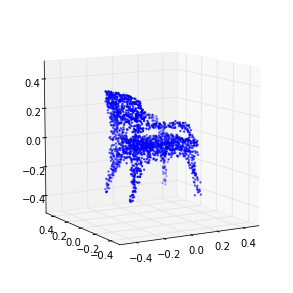

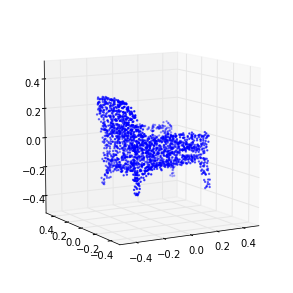

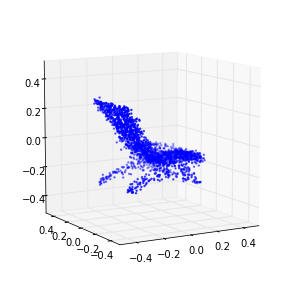

321 (-0.19123962929955235, -0.18832885611940314)
322 (-0.19390285456622089, -0.1905190309992543)
323 (-0.19231746384391077, -0.18410696861920534)
324 (-0.19268502471623597, -0.18862979334813576)
325 (-0.19132505997463509, -0.18358556815871485)
326 (-0.19036806965315783, -0.20096960387848042)
327 (-0.19200637009408739, -0.18064830314230035)
328 (-0.19136711049962926, -0.18251357917432431)
329 (-0.19225741834552199, -0.18434351627473478)
330 (-0.19259614547093709, -0.18472874826855129)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-330 is not in all_model_checkpoint_paths. Manually adding it.


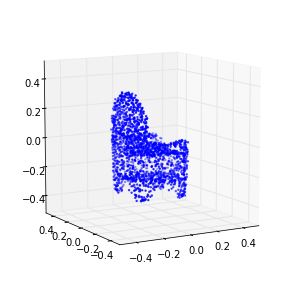

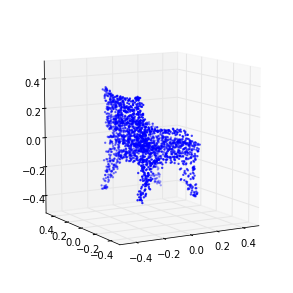

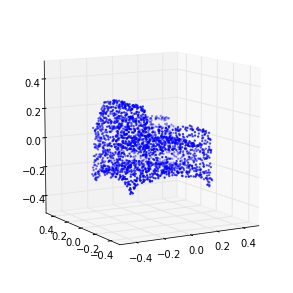

331 (-0.19058253113870269, -0.18737157903335713)
332 (-0.19121569682050635, -0.1838638644527506)
333 (-0.19153886812704582, -0.1787378473414315)
334 (-0.19371531197318323, -0.19037058673523091)
335 (-0.19483446997624856, -0.17148673865530226)
336 (-0.19009717857396161, -0.18927542699707878)
337 (-0.19461465820118232, -0.17969781160354614)
338 (-0.19096110430028704, -0.18556887904802957)
339 (-0.19096105131838056, -0.18923647315413863)
340 (-0.1922693145495874, -0.17661129214145518)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-340 is not in all_model_checkpoint_paths. Manually adding it.


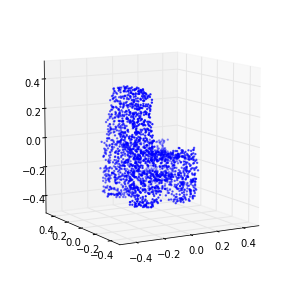

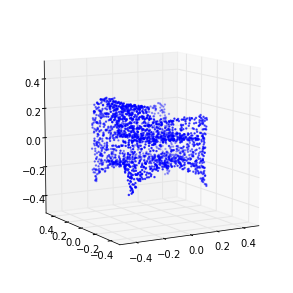

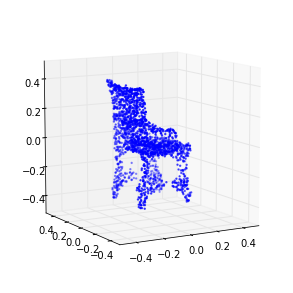

341 (-0.18996440437104967, -0.17977415742697539)
342 (-0.1923648100208353, -0.18307768139574263)
343 (-0.19328732722335393, -0.17478909647023236)
344 (-0.1918573758116475, -0.17293231244440432)
345 (-0.19378084115408084, -0.17745737952214699)
346 (-0.19184737591831771, -0.17915032141738468)
347 (-0.1922653646380813, -0.17204625159502029)
348 (-0.19179836290853994, -0.17634827064143288)
349 (-0.19189694799758769, -0.16934354410127359)
350 (-0.19300695227252113, -0.17591614745281361)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-350 is not in all_model_checkpoint_paths. Manually adding it.


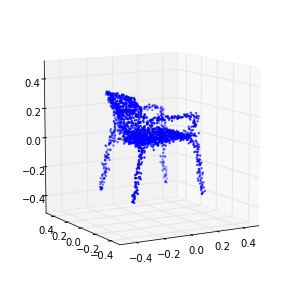

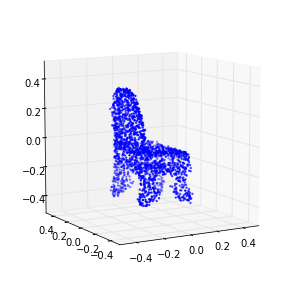

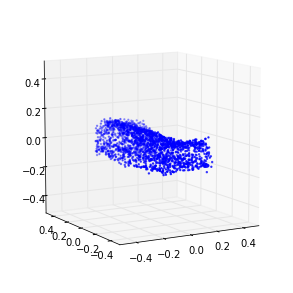

351 (-0.19275609232761243, -0.16983705538290519)
352 (-0.19480993096475249, -0.18138588744181175)
353 (-0.19281889420968515, -0.17648915118641323)
354 (-0.19402570481653567, -0.17779055624096482)
355 (-0.19298793408605788, -0.17431978163895784)
356 (-0.19085853237796713, -0.16964345618530555)
357 (-0.19409144399342715, -0.1789367370031498)
358 (-0.19164068411897731, -0.17120743736072822)
359 (-0.19453474603317403, -0.16866120751257296)
360 (-0.19243193500571781, -0.17240387311688177)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-360 is not in all_model_checkpoint_paths. Manually adding it.


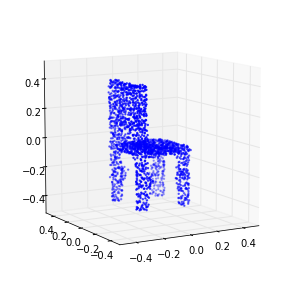

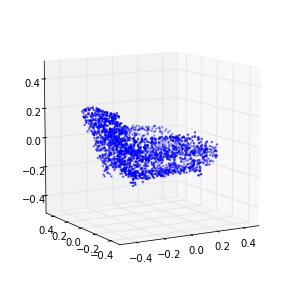

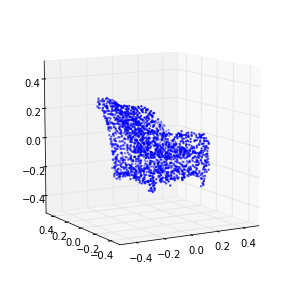

361 (-0.19294033613469866, -0.16488575245495196)
362 (-0.19612554543548161, -0.1694592618279987)
363 (-0.19303370062951689, -0.16009385883808136)
364 (-0.19266548785898421, -0.17221198093008111)
365 (-0.19133293154063047, -0.16066897384546422)
366 (-0.19181465219568322, -0.1740636091541361)
367 (-0.19246000305370048, -0.16260159622739861)
368 (-0.19429180864934567, -0.16720717924612541)
369 (-0.19389075714128989, -0.16055104053682751)
370 (-0.19037841845441747, -0.16856649076497113)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-370 is not in all_model_checkpoint_paths. Manually adding it.


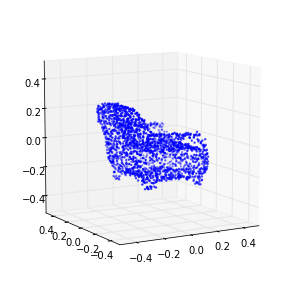

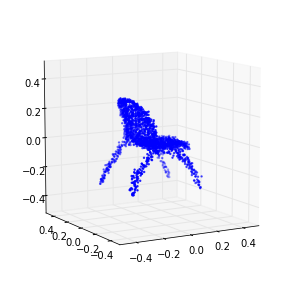

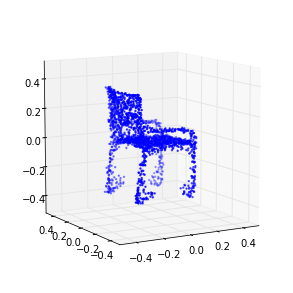

371 (-0.19014853393590009, -0.16434877062285388)
372 (-0.19148140626925009, -0.16508566781326575)
373 (-0.1925653628729008, -0.15818387656300156)
374 (-0.1939564405216111, -0.15831922160254586)
375 (-0.19541760749287077, -0.14520441133666923)
376 (-0.19243146920645679, -0.15621286244304092)
377 (-0.19182940743587634, -0.15387304320379538)
378 (-0.19411034639234895, -0.15567898253599802)
379 (-0.19265887604819404, -0.15864484950348182)
380 (-0.19388882440549357, -0.15497182861522393)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-380 is not in all_model_checkpoint_paths. Manually adding it.


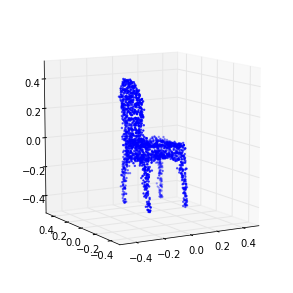

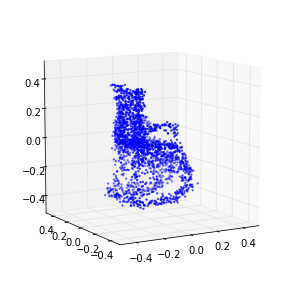

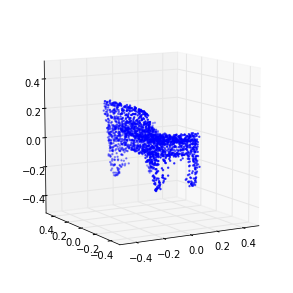

381 (-0.19317660668381939, -0.15760718506795388)
382 (-0.19191191417199593, -0.15443476924189814)
383 (-0.19108261046586214, -0.15025160351285227)
384 (-0.19443844181519968, -0.14549022361084266)
385 (-0.19344006710582309, -0.14859691952113752)
386 (-0.19330701176766996, -0.15337660218830462)
387 (-0.19337301011438723, -0.15227886289358139)
388 (-0.1924691366928595, -0.14781496866985602)
389 (-0.19178744477254372, -0.15151437096021794)
390 (-0.19347814222176871, -0.148950541736903)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-390 is not in all_model_checkpoint_paths. Manually adding it.


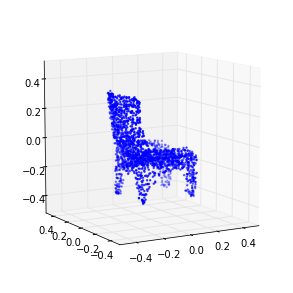

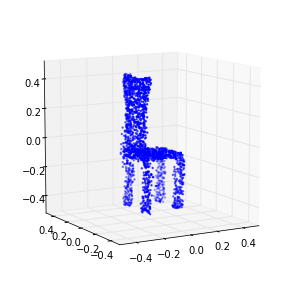

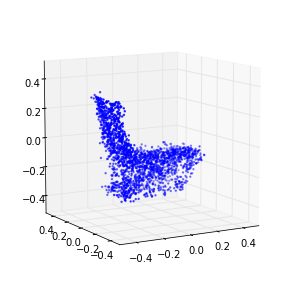

391 (-0.1946718849517681, -0.14618293361531365)
392 (-0.19385897208143163, -0.14768409839382879)
393 (-0.19364770579117316, -0.15295199360008593)
394 (-0.19296577098192991, -0.15197111721392031)
395 (-0.19221604289831939, -0.15045121505304618)
396 (-0.19585088977107296, -0.15081770138608086)
397 (-0.19160160234680881, -0.14631596980271516)
398 (-0.19147903808840999, -0.14208769411952407)
399 (-0.19221858470528214, -0.14497680410190864)
400 (-0.19195919886783316, -0.13472860885990989)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-400 is not in all_model_checkpoint_paths. Manually adding it.


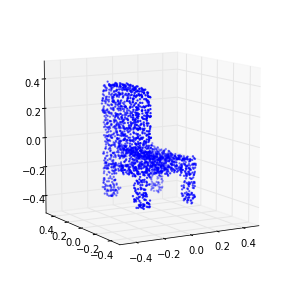

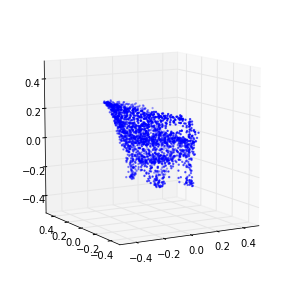

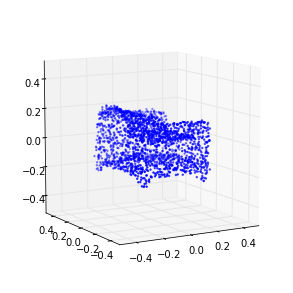

401 (-0.19165809562912695, -0.14578385237190458)
402 (-0.19401716523700291, -0.14034404936763975)
403 (-0.19128975161799677, -0.14265121326402383)
404 (-0.19502145758381598, -0.14575803252281966)
405 (-0.19186654399942468, -0.14239400735607854)
406 (-0.19440132478872935, -0.14556806727691932)
407 (-0.1908952212995953, -0.14020462554913979)
408 (-0.19422949508384421, -0.13944392927266933)
409 (-0.18971881447014985, -0.12679242287521009)
410 (-0.19499312981411263, -0.14394596577794463)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-410 is not in all_model_checkpoint_paths. Manually adding it.


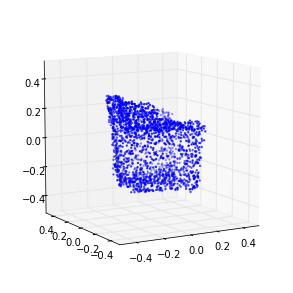

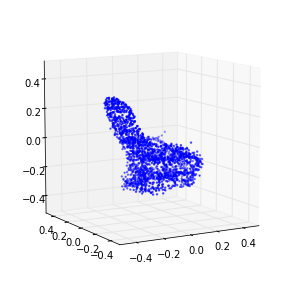

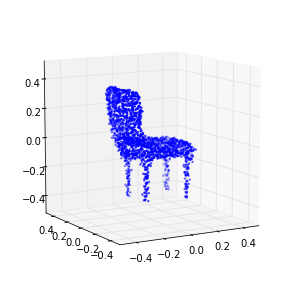

411 (-0.19244967401027679, -0.13847952722399323)
412 (-0.19043331129683388, -0.13732618121085344)
413 (-0.19379274271152638, -0.12674525242160867)
414 (-0.19215021354180795, -0.13183061419813721)
415 (-0.19191224729573286, -0.13853986202566712)
416 (-0.1915201563526083, -0.1387586055530442)
417 (-0.19419498929270992, -0.12483517411682341)
418 (-0.19355740955582371, -0.13931021149511691)
419 (-0.19009286341843781, -0.13099269651704365)
420 (-0.19340670627576334, -0.13403649545378155)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-420 is not in all_model_checkpoint_paths. Manually adding it.


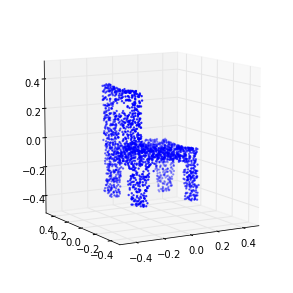

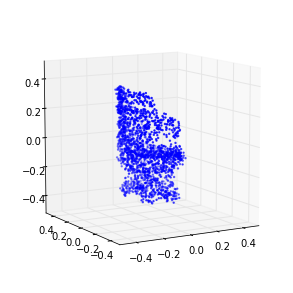

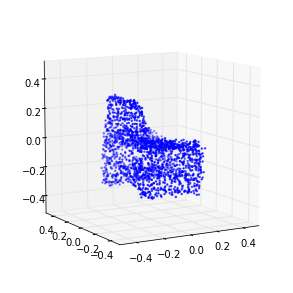

421 (-0.19083587692843543, -0.13526875332549768)
422 (-0.19153256328017623, -0.12380740405232818)
423 (-0.19289389368560578, -0.12714430551837991)
424 (-0.19348252757831855, -0.12198880149258508)
425 (-0.19121243997856421, -0.12792744901445177)
426 (-0.1925489824127268, -0.12960524525907305)
427 (-0.19021251930130853, -0.13564928593458953)
428 (-0.19111523214313719, -0.12415626396735509)
429 (-0.19319775976516582, -0.12456696618486333)
430 (-0.19374472520969532, -0.13027821950338506)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-430 is not in all_model_checkpoint_paths. Manually adding it.


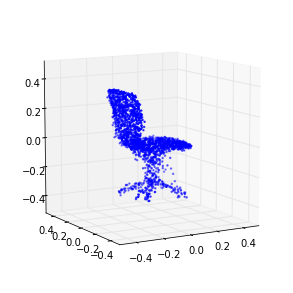

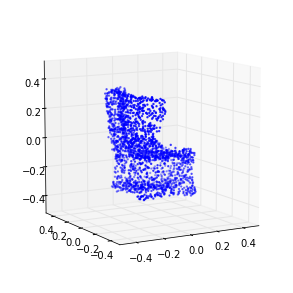

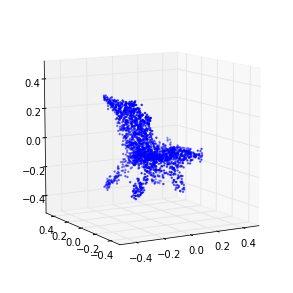

431 (-0.19220425663170992, -0.11959431182455134)
432 (-0.19240190817250147, -0.12936094899972281)
433 (-0.18918213435897122, -0.13480876910465736)
434 (-0.1921053652410154, -0.12532779739962685)
435 (-0.19252354359185253, -0.12966896372812767)
436 (-0.19101199927153412, -0.122653863772198)
437 (-0.19503908631978212, -0.11962322863163771)
438 (-0.19103685010362553, -0.13049515060804509)
439 (-0.19411305586496988, -0.12111064019026579)
440 (-0.19361543180765928, -0.1338992303720227)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-440 is not in all_model_checkpoint_paths. Manually adding it.


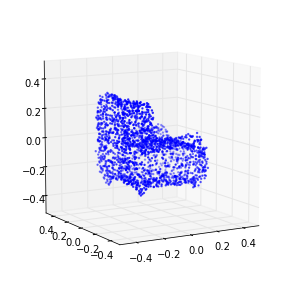

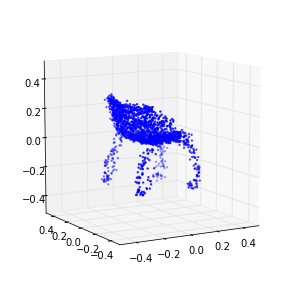

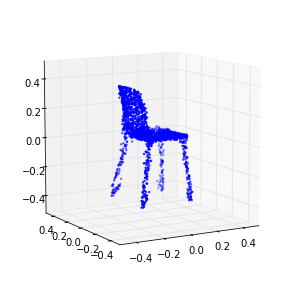

441 (-0.19155440352581166, -0.13593781573904884)
442 (-0.19449579097606517, -0.13218809333112505)
443 (-0.19425496028529274, -0.13893008590848357)
444 (-0.1909431074504499, -0.12867210777821364)
445 (-0.19368598455632174, -0.13296790365819577)
446 (-0.1926782637834549, -0.13874727404779857)
447 (-0.19331276659612304, -0.13345660158881434)
448 (-0.19347380532158745, -0.13195499474251712)
449 (-0.19199271235201093, -0.12555758903423944)
450 (-0.19098614514977844, -0.13197595736494772)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-450 is not in all_model_checkpoint_paths. Manually adding it.


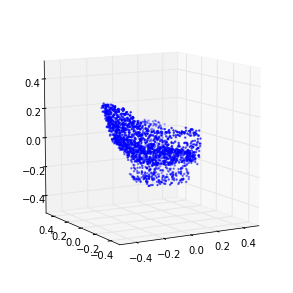

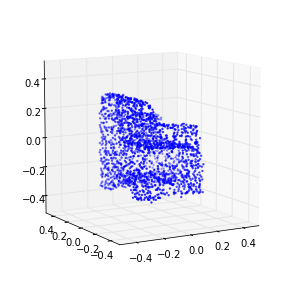

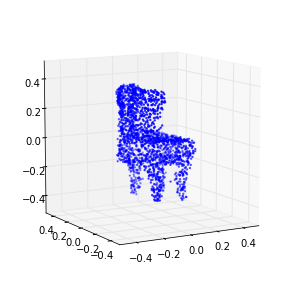

451 (-0.19031738473309412, -0.12880215379926893)
452 (-0.19111533507152839, -0.13352845416024881)
453 (-0.19343420664469402, -0.13412393188035046)
454 (-0.19057941983143489, -0.12346477751378659)
455 (-0.19206524557537502, -0.12647114721713243)
456 (-0.19163374818033643, -0.12089674119596128)
457 (-0.18955221253412741, -0.12252687718029376)
458 (-0.19395540908530906, -0.12402160741664746)
459 (-0.19232563381945644, -0.12950958421936742)
460 (-0.1921468917970304, -0.117179775679553)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-460 is not in all_model_checkpoint_paths. Manually adding it.


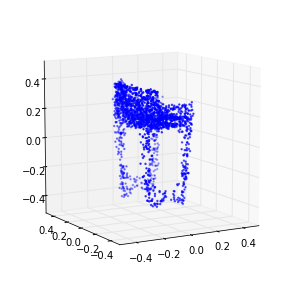

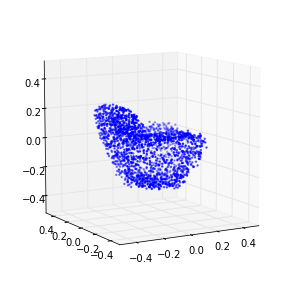

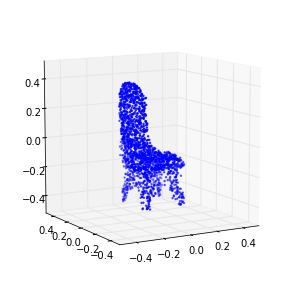

461 (-0.19343754042077949, -0.11985802512477946)
462 (-0.19443414719016464, -0.12292424175474378)
463 (-0.19197923419652163, -0.12258264836337832)
464 (-0.19108551177713606, -0.12389814522531298)
465 (-0.19225770201947953, -0.12151817204775633)
466 (-0.19201194710201688, -0.12066163729738306)
467 (-0.19157651011590604, -0.12420964958491149)
468 (-0.19041008066248011, -0.11986984947213421)
469 (-0.1928306151319433, -0.12231304606905689)
470 (-0.19050553143024446, -0.13224521279335022)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-470 is not in all_model_checkpoint_paths. Manually adding it.


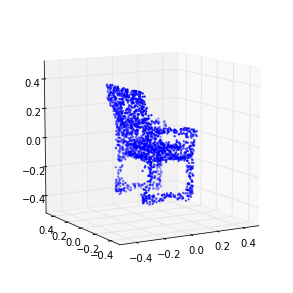

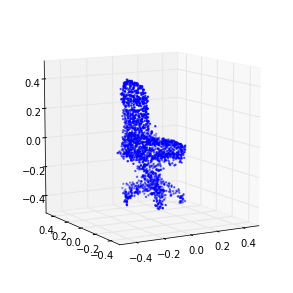

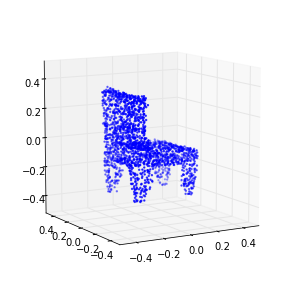

471 (-0.19060209658410815, -0.10986732222415783)
472 (-0.19131294853157468, -0.12781799805385094)
473 (-0.19156141656416434, -0.12630554040273032)
474 (-0.19256213605403899, -0.11834422443751935)
475 (-0.19036353020756333, -0.12470780202636013)
476 (-0.19247805939780341, -0.11541430376194141)
477 (-0.1907463479925085, -0.11500482619912536)
478 (-0.19078240990638734, -0.11943986239256682)
479 (-0.19131796028878953, -0.11885049552829177)
480 (-0.19141074904689082, -0.11831043991777632)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-480 is not in all_model_checkpoint_paths. Manually adding it.


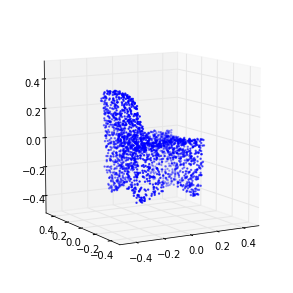

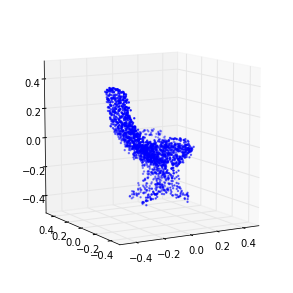

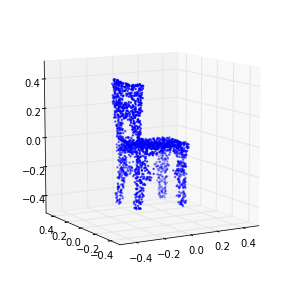

481 (-0.18944151059344963, -0.11004160592953365)
482 (-0.191780979986544, -0.12326395428842968)
483 (-0.19317204025056628, -0.11028139845088676)
484 (-0.19210843499060029, -0.11120809863011043)
485 (-0.19080014946284118, -0.11228646862286108)
486 (-0.19233327783920146, -0.11826596298703441)
487 (-0.19064777405173691, -0.10833856877353457)
488 (-0.19167019272292102, -0.11462378087970945)
489 (-0.1894978399629946, -0.10830261530699553)
490 (-0.19284230558960527, -0.11472732049447519)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-490 is not in all_model_checkpoint_paths. Manually adding it.


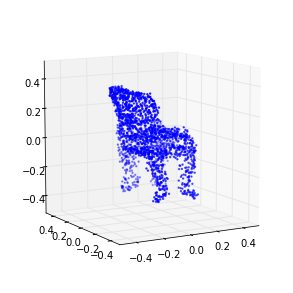

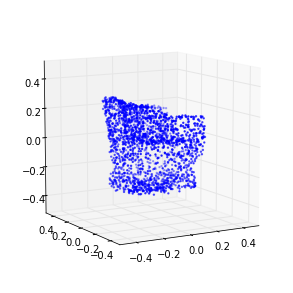

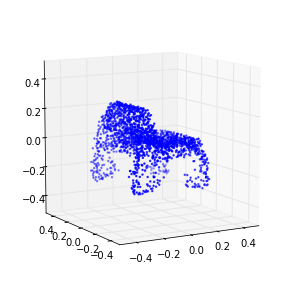

491 (-0.19303005127995101, -0.1017729612412276)
492 (-0.1912575152185228, -0.10439809163411458)
493 (-0.19186172397048384, -0.10000817394918865)
494 (-0.19263594117429522, -0.10020716929877246)
495 (-0.19194960252002433, -0.11022961167273698)
496 (-0.19150486864425517, -0.10782586452033785)
497 (-0.19185114872676354, -0.10870335858177256)
498 (-0.19115463627709284, -0.10648546726615341)
499 (-0.19013458578674883, -0.10669306389711521)
500 (-0.19015932193508855, -0.11000508097586809)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/nn_models/gan/nb_gan/nb_wgan_gp_ae_14_emd_chair_2048_best_epoch/models.ckpt-500 is not in all_model_checkpoint_paths. Manually adding it.


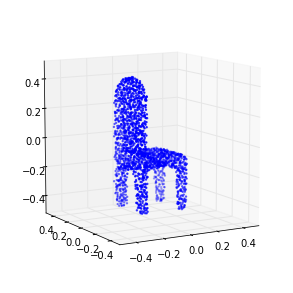

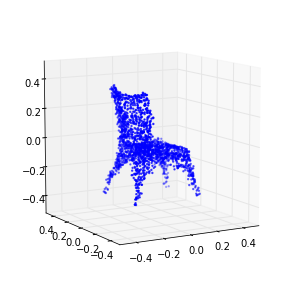

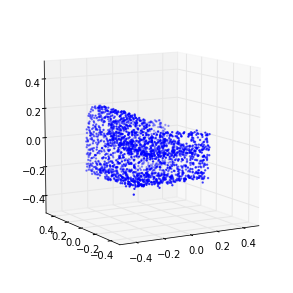

In [10]:
save_dir = osp.join(synthetic_data_out_dir, experiment_name)
save_dir = create_dir(save_dir)

buf_size = 1 # flush each line
if do_training:    
    train_stats = []
    log_file = open(osp.join(train_dir, 'train_stats.txt'), 'a', buf_size)
    for _ in range(max_epochs):        
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss                
        log_file.write('%04d\t%.9f\t%.9f\t%.4f\n' % (epoch, loss[0], loss[1], duration / 60.0))        

        if save_model and (epoch % saver_step == 0 or epoch <= 5):
            checkpoint_path = osp.join(train_dir, model_saver_id)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
            syn_latent_data = gan.generate(n_syn_samples, noise_params)
            syn_data = ae.decode(syn_latent_data)
            np.savez(osp.join(save_dir, 'epoch_' + str(epoch)), syn_data)
            for k in range(3):
                Point_Cloud(syn_data[k]).plot(in_u_sphere=True)
                        
        train_stats.append((epoch,) + loss)
    log_file.close()

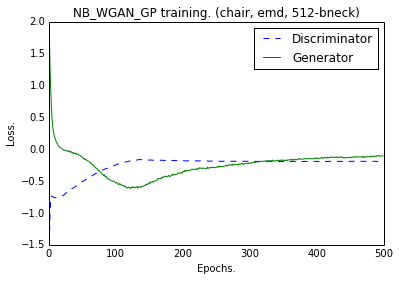

In [11]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('NB_WGAN_GP training. (%s, %s, %s-bneck)' %(class_name, ae_loss, ae.bottleneck_size))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')
    
    plt.savefig(osp.join(train_dir, 'training_curve.png'))